# Apartment for rent classified
This notebook contains the stages to execute an end-to-end process to obtain a regression model of apartment rent based on their characteristics.

In [1]:
import os
import sys
import warnings
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

## Load data

In [2]:
def load_data(filepath: str) -> pd.DataFrame:
    data = pd.DataFrame()
    for file in os.listdir(filepath):
        if file.endswith(".csv"):
            parcial_data = pd.read_csv(os.path.join(filepath, file), sep=";", encoding='cp1252')
            data = pd.concat([data, parcial_data], axis=0)
        print(f"Shape of the {file} is: {parcial_data.shape}")
    return data

def explore_data(data: pd.DataFrame) -> None:
    print(data.head())
    print("\nDataset info")
    print(data.info())
    num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    print(f'Numerical columns ({len(num_cols)}): {num_cols}')
    cat_cols = data.select_dtypes(include=['object']).columns.tolist()
    print(f'Categorical columns ({len(cat_cols)}): {cat_cols}')
    print("\nDataset numerical description")
    print(data.describe().T)
    print("\nDataset categorical description")
    print(data.describe(include=['object']).T)
    print("\nMissing values %")
    print(data.isna().mean()*100)

## Visualizing data

In [3]:
def plot_hist(data: pd.DataFrame) -> None:
    data.hist(bins=20, figsize=(20, 10))
    plt.suptitle("Histograms of numerical columns", fontsize=20)
    plt.show()

def plot_bar(data: pd.DataFrame) -> None:
    obj_cols = data.select_dtypes(include=['object']).columns
    fig, axes = plt.subplots(7, 2, figsize=(12, 22))
    axes = axes.flatten()
    for ax, col in zip(axes, obj_cols):
        if data[col].nunique() < 50:
            data[col].value_counts().plot(kind='bar', ax=ax, title=col)
            ax.tick_params(axis='x', labelrotation = 50)
        else:
            ax.text(0.5, 0.5, f"'{col}' has {data[col].nunique()} unique values", horizontalalignment='center', verticalalignment='center')
            ax.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False) 
    plt.suptitle("Bar plots of categorical columns", fontsize=20)
    plt.tight_layout()
    plt.show()

def plot_corr(data: pd.DataFrame) -> None:
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f", center=0, square=True, linewidths=.5)
    plt.title("Correlation matrix")
    plt.show()

## Preprocessing and feature engineering

In [4]:
def drop_duplicates(data: pd.DataFrame) -> pd.DataFrame:
    data.drop_duplicates(inplace=True)
    return data

def fill_missing_values(data: pd.DataFrame) -> pd.DataFrame:
    # fill missing values with median
    for col in ['bathrooms', 'bedrooms', 'latitude', 'longitude']:
        data[col].fillna(data[col].median(), inplace=True)

    # fill missing values with new category
    data['pets_allowed'].fillna('unknown', inplace=True)
    return data

def drop_columns(data: pd.DataFrame) -> pd.DataFrame:
    # unnecessary columns
    data.drop(columns =["id", "title", "body", "time", "price_display"], inplace=True)
    # constant columns
    data.drop(columns=["category", "currency", "fee", "price_type"], inplace=True)
    # high cardinality columns
    data.drop(columns=["amenities", "address", "cityname", "state", "source"], inplace=True)
    return data

def remove_nans(data: pd.DataFrame) -> pd.DataFrame:
    # Remove rows with missing target
    data.dropna(subset=["price"], inplace=True)
    # Remove no bedrooms
    data = data[data["bedrooms"] > 0]
    return data

def encode_categorical(data: pd.DataFrame) -> pd.DataFrame:
    categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
    data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
    return data

def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    # Drop duplicates
    data = drop_duplicates(data)
    # Fill missing values
    data = fill_missing_values(data)
    # Drop columns
    data = drop_columns(data)
    # Remove nans
    data = remove_nans(data)
    # Encode categorical columns
    data = encode_categorical(data)
    data.to_csv("..\data\interim\preprocessed_data.csv", index=False)
    return data

## Split data

In [5]:
def scale_features(X_train: pd.DataFrame, X_test: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    return X_train_scaled, X_test_scaled

def split_data(data: pd.DataFrame, target: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    X = data.drop(columns=[target])
    y = data[target]
    y = np.log(y)   # log transform the target to normalize it
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_test = scale_features(X_train, X_test)
    X_train.to_csv("..\data\processed\X_train.csv", index=False)
    X_test.to_csv("..\data\processed\X_test.csv", index=False)
    y_train.to_csv("..\data\processed\y_train.csv", index=False)
    y_test.to_csv("..\data\processed\y_test.csv", index=False)
    return X_train, X_test, y_train, y_test

## Train

In [6]:
def train(X_train: pd.DataFrame, y_train: pd.Series) -> XGBRegressor:
    model = XGBRegressor()
    model.fit(X_train, y_train)
    return model

## Evaluate

In [7]:
def plot_regression(y_test: pd.Series, y_pred: np.ndarray, rmse: float, mse: float, r2: float) -> None:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=y_test, y=y_pred)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel("Actual price")
    plt.ylabel("Predicted price")
    plt.title("Actual vs Predicted price (scaled)")
    plt.text(min_val, max_val, f"RMSE: {rmse:.4f}", va='top')
    plt.text(min_val, max_val-(max_val/24), f"MSE: {mse:.4f}", va='top')
    plt.text(min_val, max_val-(max_val/12), f"R2: {r2:.4f}", va='top')
    plt.show()

def plot_feature_importance(model: XGBRegressor, X: pd.DataFrame) -> None:
    features = X.columns
    importances = model.feature_importances_
    ax = plt.axes()
    indices = np.argsort(importances)
    plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.title('Feature importance')
    plt.show()

def eval(model: XGBRegressor, X_test: pd.DataFrame, y_test: pd.Series) -> None:
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")
    plot_regression(y_test, y_pred, rmse, mse, r2)
    plot_feature_importance(model, X_test)

## Main

Shape of the apartments_for_rent_classified_100K.csv is: (99492, 22)
Shape of the apartments_for_rent_classified_10K.csv is: (10000, 22)
           id                category                            title  \
0  5668640009  housing/rent/apartment       One BR 507 & 509 Esplanade   
1  5668639818  housing/rent/apartment      Three BR 146 Lochview Drive   
2  5668639686  housing/rent/apartment  Three BR 3101 Morningside Drive   
3  5668639659  housing/rent/apartment            Two BR 209 Aegean Way   
4  5668639374  housing/rent/apartment         One BR 4805 Marquette NE   

                                                body amenities  bathrooms  \
0  This unit is located at 507 & 509 Esplanade, R...       NaN        1.0   
1  This unit is located at 146 Lochview Drive, Ne...       NaN        1.5   
2  This unit is located at 3101 Morningside Drive...       NaN        2.0   
3  This unit is located at 209 Aegean Way, Vacavi...       NaN        1.0   
4  This unit is located at 4805 M

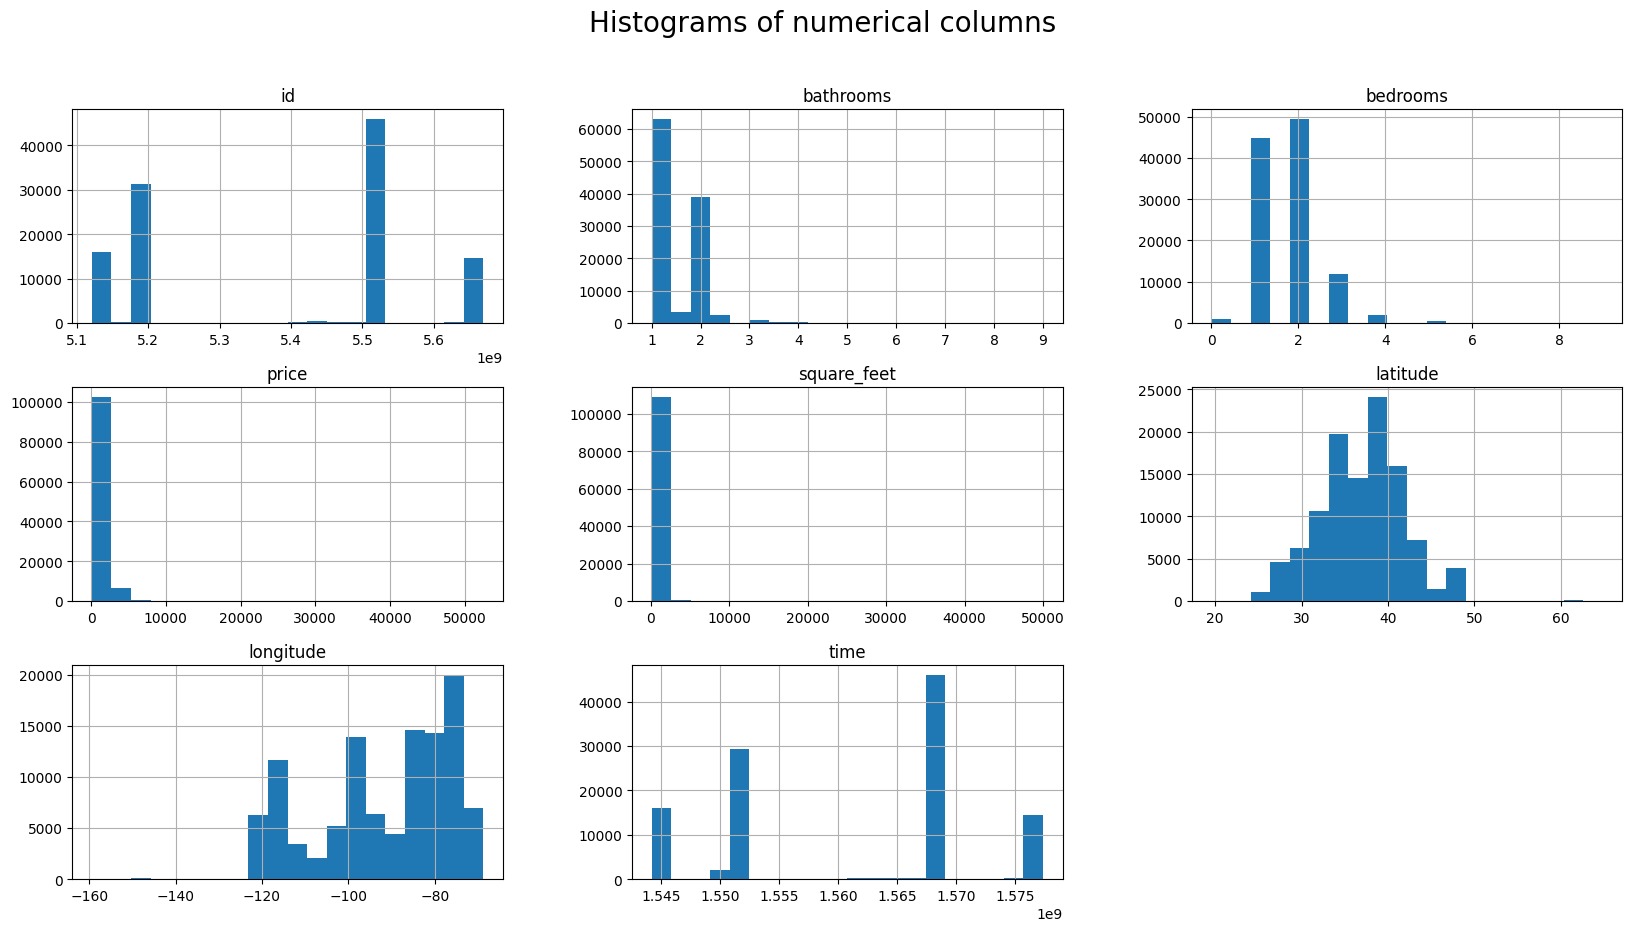

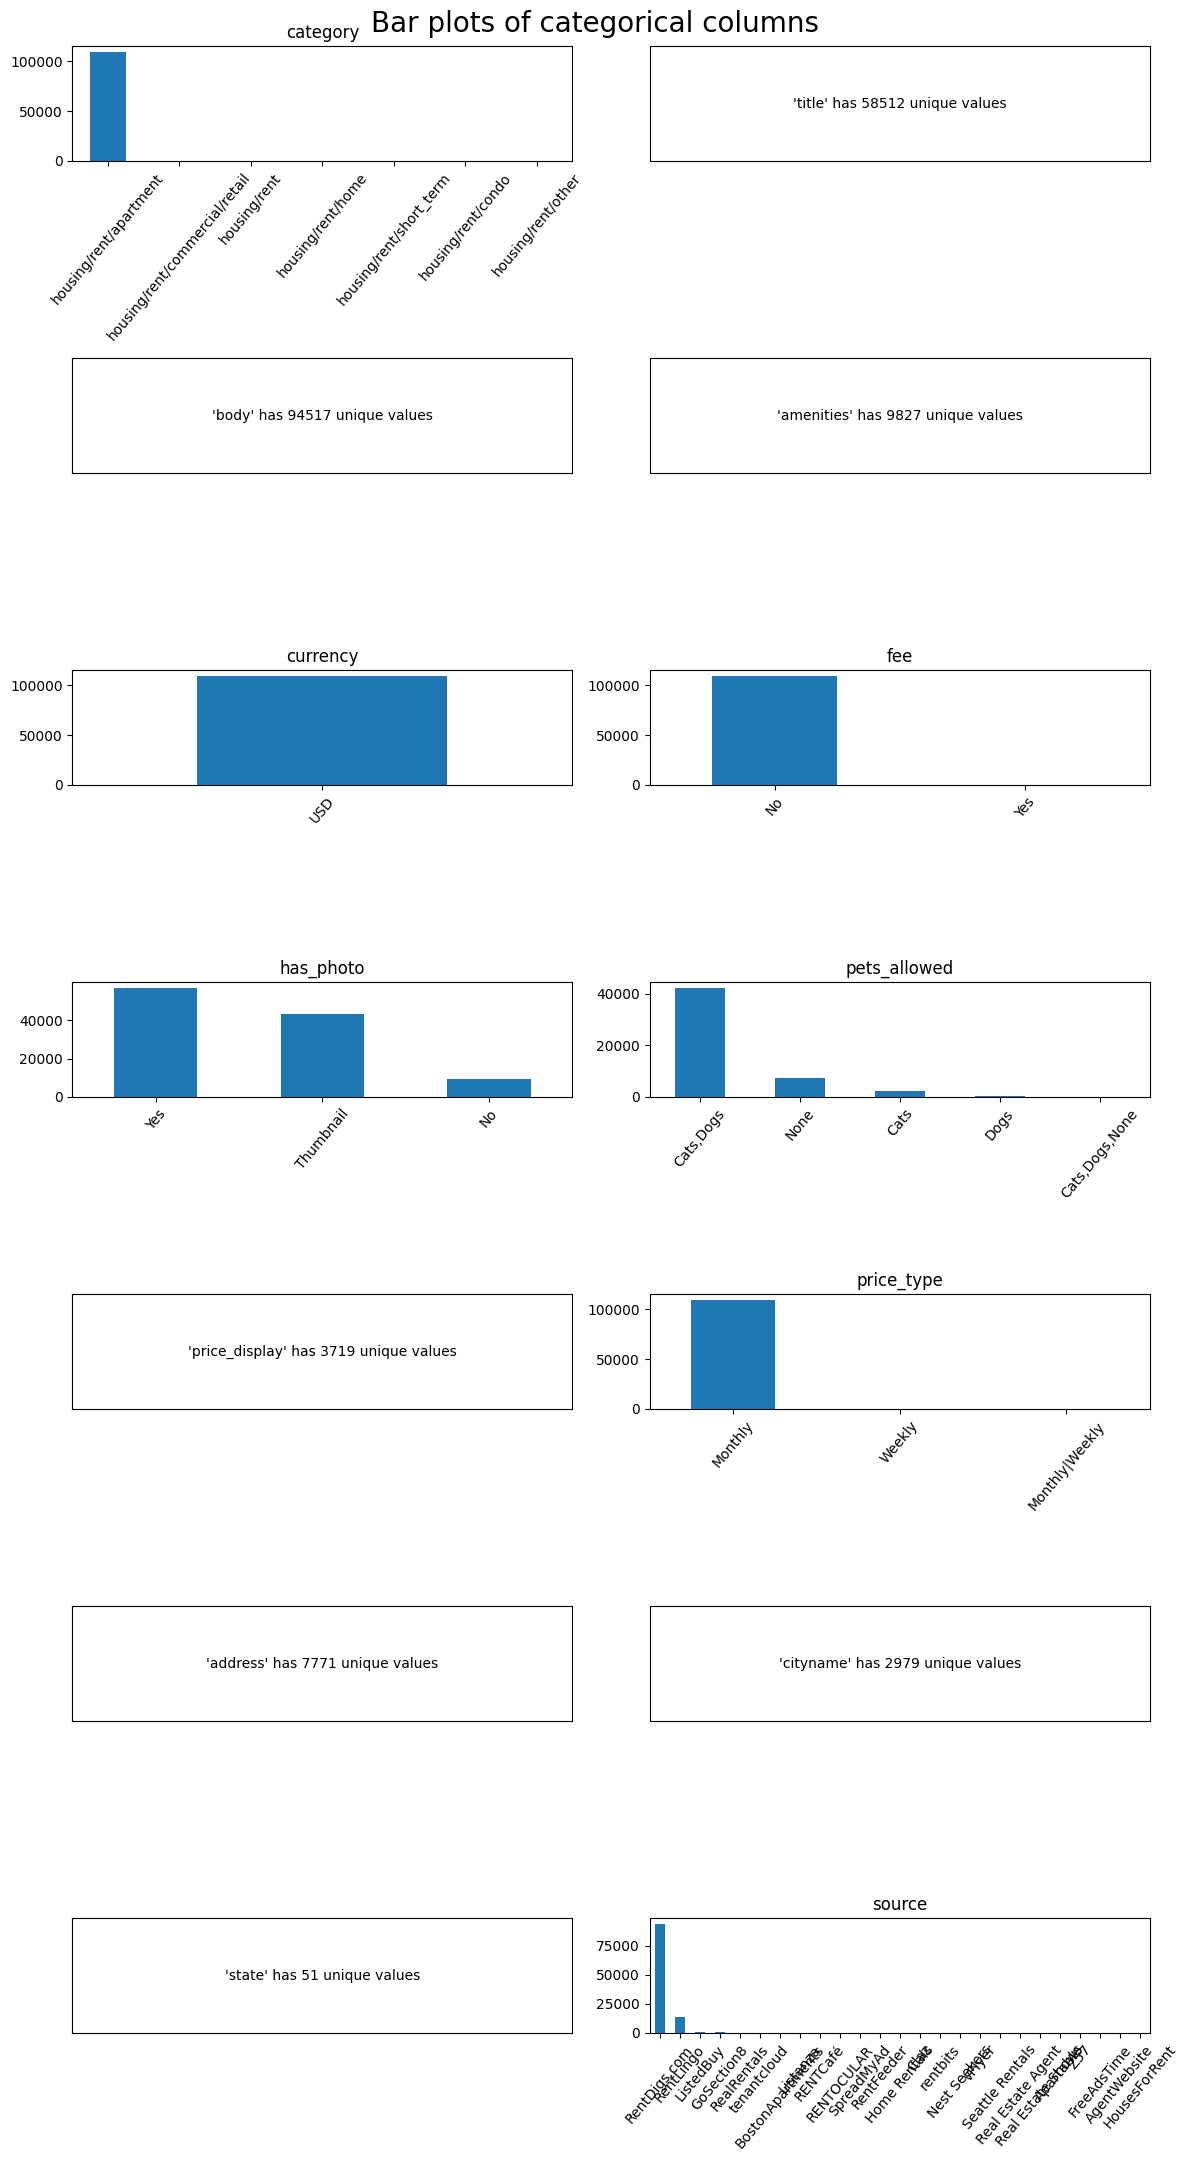

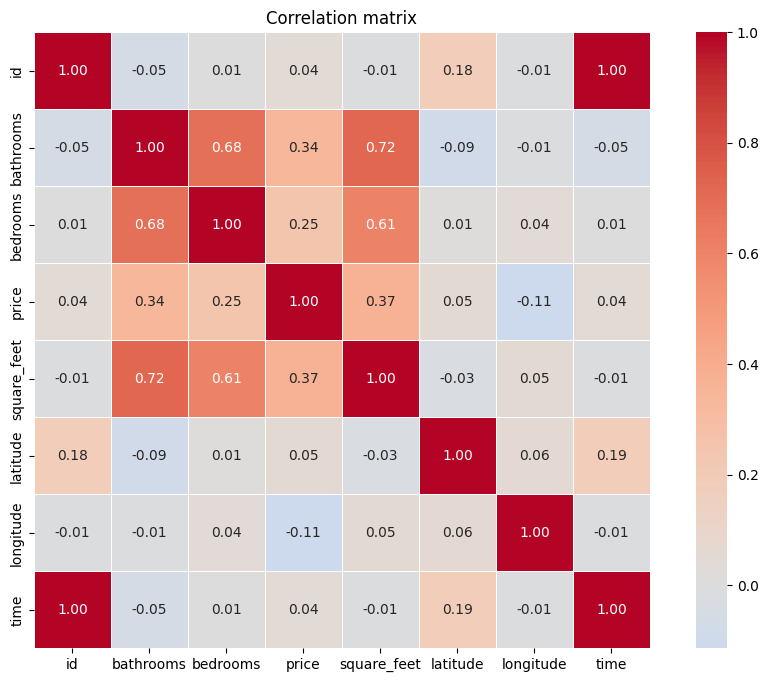

RMSE: 0.1900
MSE: 0.0361
R2: 0.8138


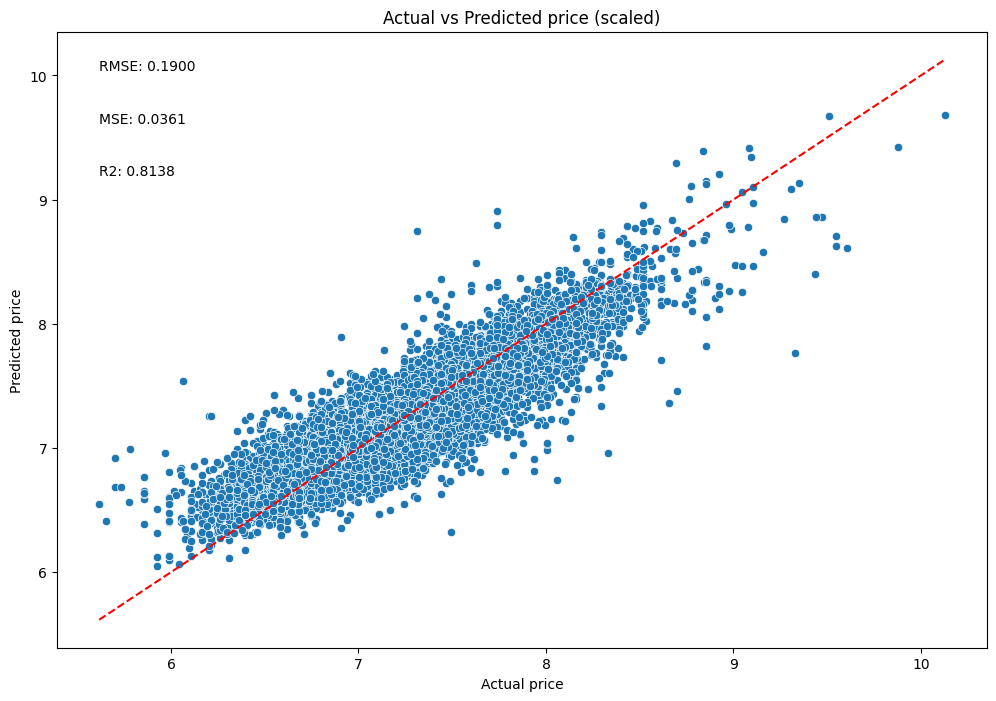

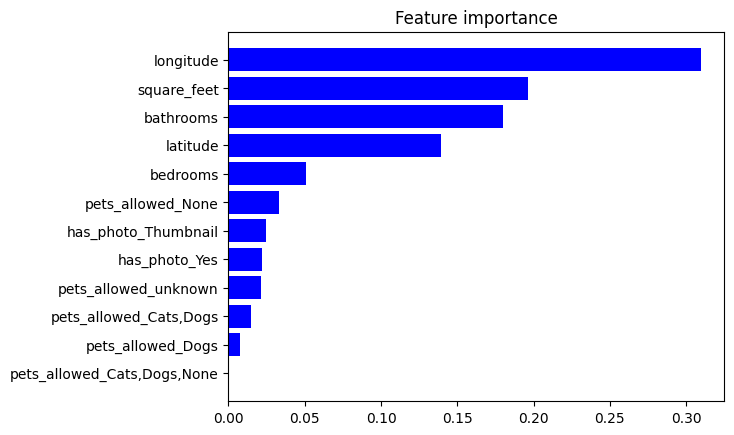

In [8]:
def main(filepath: str) -> None:
    # Load data
    data = load_data(filepath)
    # Explore data
    explore_data(data)
    plot_hist(data)
    plot_bar(data)
    plot_corr(data)
    # Preprocess data
    data = preprocess_data(data)
    # Split data
    X_train, X_test, y_train, y_test = split_data(data, target="price")
    # Train model
    model = train(X_train, y_train)
    # Evaluate model
    eval(model, X_test, y_test)

main(r"..\data\raw")